# LIBRERIAS A USAR

## Instalamos las dependecias necesarias

In [128]:
# !pip3 install --upgrade wandb
# !pip install scikit-learn

## Importamos las librerias y sus submodulos

In [129]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

In [130]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [131]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
wandb.login()

True

## Definimos los híper-parámetros

In [132]:
lr = 0.005 #Learning rate
epochs = 100
bs = 120 #batch size
loss = "mse"
optimizer = "ADAM"
regularizer = "NA"

In [133]:
run = wandb.init(
    settings=wandb.Settings(x_disable_stats=False, x_stats_sampling_interval = 1.0),
    # set the wandb project where this run will be logged
    name = "Intento_con_dos_capas",
    project = "Creacion_de_regresion_lineal",
    group = "Capa_de_polinomio_personalizada",

    # track hyperparameters and run metadata with wandb.config
    config = {
        "layer_1": "NA",
        "activation": "relu",
        "w_initializer": "He Initialization",
        "optimizer": optimizer,
        "loss": loss,
        "metric": "mse",
        "epoch": epochs,
        "batch_size": bs,
        "layer_quantity": 1,
        "regularizer": regularizer,
        "Modelo": "Pol"
    }
)
time.sleep(3.0)

# Antes de empezar

## Creamos el nuevo layer polinomial

In [134]:
class PolynomialTransform(tf.keras.layers.Layer):
    def __init__(self, degree):
        super(PolynomialTransform,self).__init__()
        
        self.num_outputs = degree + 1 #Se define la cantidad de potencias con las que se trabajara (incluido el 0)
        self.powers =  tf.range(start = 0.0, limit = self.num_outputs) #Se crea el array de potencias 
        self.kernel = self.add_weight(name = "kernel", shape=[self.num_outputs]) #Se crea el array de pesos

    def poly_terms(self, inputs):
        #Garantizamos que se aplique a cualquier dato, array o no
        inputs = tf.convert_to_tensor(inputs)
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)
       
        #Sacamos la longitud del batch para conseguir la matriz de potencias
        batch = tf.shape(inputs)[0]

        #Expandimos los array de entrada y de potencias para que sean compatibles
        inputs_expanded = tf.expand_dims(inputs, axis=-1)  #[batch, 1, 1]
        powers_expanded = tf.expand_dims(self.powers, axis=0)  #[1, num_outputs]
        powers_expanded = tf.expand_dims(powers_expanded, axis=0)  #[1, 1, num_outputs]
    
        poly_terms = tf.math.pow(inputs_expanded, powers_expanded)  #[batch, 1, num_outputs]
        poly_terms = tf.squeeze(poly_terms, axis=1)  #[batch, num_outputs]
        return poly_terms

    def polynomial(self, inputs, coefficients):
        terms = self.poly_terms(inputs)
        coefficients = tf.convert_to_tensor(coefficients, dtype=tf.float32)
        coefficients = tf.reshape(coefficients, [self.num_outputs])  
        return tf.tensordot(terms, coefficients, 1) #[batch] --> batch_i = a_i*(x**i)
    
    def call(self, inputs):
        terms = self.poly_terms(inputs)
        terms = tf.tensordot(terms, self.kernel, 1) #[batch] --> batch_i = a_i*(x**i)
        return tf.expand_dims(terms, axis = -1)

### Verificamos su funcionalidad

In [135]:
# prueba1 = PolynomialTransform(degree = 3) #Definimos un polinomio de grado 3
# delta = 0.01
# x1 = tf.range(-4,4,delta = delta) #Arreglo 1D
# print(tf.shape(x1))
# res1 = prueba1(inputs = x)
# plt.scatter(x,res1)

In [136]:
# prueba2 = PolynomialTransform(degree = 5)
# x2 = tf.reshape(x1, [800,1])  # Arreglo 2D
# print(tf.shape(x2))
# res2 = prueba2(inputs = x2)
# plt.scatter(x2,res2)

## Creamos y preparamos los datos de entrenamiento

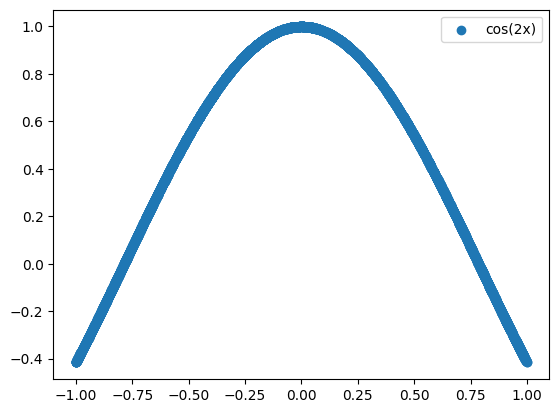

In [137]:
batch_size = 5000
Polynomial = PolynomialTransform(3)
x = tf.random.uniform((batch_size,), minval=-1, maxval=1)
y = tf.math.cos(2*x)
plt.scatter(x,y, label = "cos(2x)")
plt.legend()

In [138]:
domain = tf.reshape(x,[-1,1])
codomain_cos = tf.reshape(y,[-1,1])
domain = domain.numpy()
codomain_cos = codomain_cos.numpy()
X_train, X_test, y_train, y_test = train_test_split(domain, codomain_cos, test_size=0.2, random_state=42)

In [139]:
scale_x = StandardScaler()
scale_y = StandardScaler()
X_train, y_train = scale_x.fit_transform(X_train), scale_y.fit_transform(y_train)
X_test, y_test = scale_x.transform(X_test), scale_y.transform(y_test)

# Creamos la red neuronal

### Usamos Sequential

In [140]:
n = 3
model = keras.Sequential([
        PolynomialTransform(degree = n)
]) #Arquitectura de la red neuronal

In [141]:
model.build(input_shape = keras.Input(shape=(1,)) )
model.compile(optimizer=SGD(learning_rate = lr), loss = 'mse')
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ polynomial_transform_11         │ ?                      │   0 (unbuilt) │
│ (PolynomialTransform)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [142]:
# for layer in model.layers:
#    if hasattr(layer, 'kernel_initializer'):
#        new_weights = layer.kernel_initializer(layer.kernel.shape)
#        layer.kernel.assign(new_weights)
#    if hasattr(layer, 'bias_initializer') and layer.bias is not None:
#        new_bias = layer.bias_initializer(layer.bias.shape)
#        layer.bias.assign(new_bias)

### Entrenamos la red

In [143]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
verbose = 0
history = model.fit(X_train, y_train,
                    batch_size = bs,
                    epochs = epochs,
                    verbose = verbose,
                    validation_data = (X_test, y_test),
                    callbacks=[
                        WandbMetricsLogger(log_freq=1),
                        WandbModelCheckpoint("models/model.keras")
                    ]
                            )
run.finish()

batch/batch_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/batch_step,3399
batch/learning_rate,0.005
batch/loss,0.00892
epoch/epoch,99


# Evaluación de la red neuronal

## Evaluamos la red en el dominio [-1,1]

In [144]:
vg =  np.linspace(-1, 1, 1000).reshape(-1, 1)
x_validation = vg
x_validation = scale_x.transform(x_validation)
prediction = model.predict(x_validation)
prediction = scale_y.inverse_transform(prediction)
x_validation = vg
x = x_validation
polynomial_layer = model.layers[0]
a_is = polynomial_layer.kernel.numpy()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


### Consegimos la función en terminos de los valores normalizados

In [145]:
# a_round = np.round(a_is.flatten(), 2)
# terms = []
# for i, coef in enumerate(a_round):
#     terms.append(f"{coef:.2f}*x**{i}")

# closest_function = " + ".join(reversed(terms))
# print(closest_function)

### Escalamos los pesos normalizados para obtener el polinomio real

In [149]:
def raw_coefficients(a, mu_x, mu_y, s_x, s_y):
    x_s = tf.reshape(-1.0,[-1,1])
    b_array = np.zeros(len(a_is))
    for i, coef in enumerate(a_is):
        b_array[i] =  (s_y*coef)*((x_s-mu_x)/(x_s*s_x))**i
    b_array[0] = b_array[0] + mu_y
    return b_array


a = a_is    
mu_x, s_x = scale_x.mean_, scale_x.scale_ 
mu_y, s_y = scale_y.mean_, scale_y.scale_
raw_coefficients = raw_coefficients(a = a, mu_x = mu_x, mu_y = mu_y, s_x = s_x, s_y = s_y)
terms = []
for i, coef in enumerate(raw_coefficients):
    terms.append(f"{coef:.2f}*x**{i}")

closest_function = " + ".join(reversed(terms))
print(closest_function)

-0.00*x**3 + -1.32*x**2 + 0.01*x**1 + 0.38*x**0


## Comparamos la predicción con el modelo real

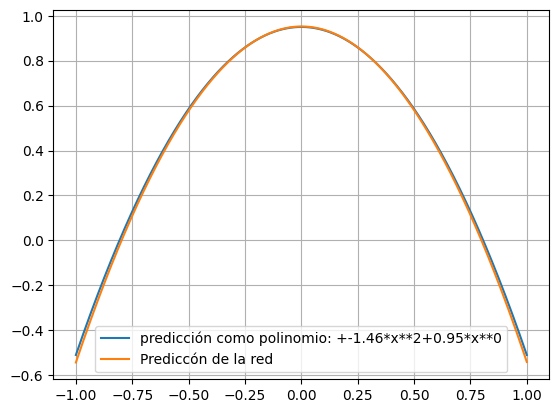

In [147]:
plt.plot(x, eval(function), label = "predicción como polinomio: " + function)
plt.plot(x_validation, prediction, label = "Prediccón de la red")
plt.legend()
plt.grid()
plt.show()

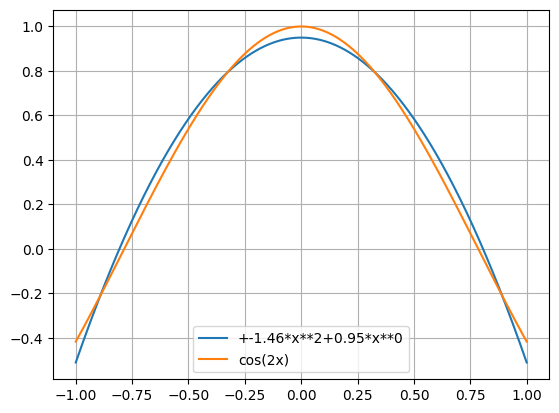

In [148]:
plt.plot(x, eval(function), label = function)
plt.plot(x_validation, np.cos(2*x_validation), label = "cos(2x)")
plt.legend()
plt.grid()
plt.show()